## Загрузка данных

In [7]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

In [10]:
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [11]:
import zipfile as zf

files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()

## Homework


### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [331]:
import pandas as pd
import numpy as np
import numba as nb
import requests
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from tqdm.auto import tqdm
from rectools import Columns

import time
from collections import defaultdict

#для numba
import sys
sys.frozen = True

#установка seed
np.random.seed(23)

In [171]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [172]:
def generate_subsample(interactions, users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [317]:
top_k = 100
users_count = 10000
df, users, recs = generate_subsample(interactions, users_count, top_k)
target = df.values

In [321]:
def mrr_naive(target, users, recs, k):
    ranks = []
    for i, user in enumerate(users):
        rank = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            rank += 1
            if rec in user_target:
                ranks.append(1/rank)
                break
    return sum(ranks) / len(users)

In [322]:
mrr_naive(target, users, recs, top_k)

0.09731721957110973

In [323]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs, k):
    ranks = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        rank = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            rank += 1
            if rec in user_target:
                ranks[i] = 1/rank
                break
    return sum(ranks) / len(users)

In [324]:
mrr_numba(target, users, recs, top_k)

0.09731721957110973

In [325]:
def mrr_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem,
                       right_on=Columns.UserItem)
    df_recs['rank_inv'] = 1 / df_recs[Columns.Rank]
    
    return df_recs.groupby(Columns.User)['rank_inv'].agg('max').sum() / len(users)

In [326]:
mrr_pandas(df, users,recs, top_k)

0.09731721957111013

In [293]:
%timeit mrr_naive(target, users, recs, top_k)

4.63 s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [294]:
%timeit mrr_numba(target, users, recs, top_k)

275 ms ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [297]:
%timeit mrr_pandas(df, users,recs, top_k)

148 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Графики

In [339]:
def get_data_for_plot ():
    methods = {'mrr_naive': mrr_naive,
               'mrr_numba': mrr_numba,
               'mrr_pandas': mrr_pandas}
    users_count = [100, 1000, 10000, 100000]
    top_k = [10, 50, 100]
    result = defaultdict(list)

    for num_users in users_count:  
        for k in top_k:  
            df, users, recs = generate_subsample(interactions, num_users, k)
            target = df.values

            for method, func_method in methods.items():
                print(num_users,k,method)
                if method == 'mrr_pandas':
                    data = df
                else:
                    data = target

                start_time = time.time()
                mrr = func_method(data, users, recs, k)
                func_time = time.time() - start_time

                result[num_users].append((method, k, func_time))
    return result

In [340]:
plot_data = get_data_for_plot ()

100 10 mrr_naive
100 10 mrr_numba
100 10 mrr_pandas
100 50 mrr_naive
100 50 mrr_numba
100 50 mrr_pandas
100 100 mrr_naive
100 100 mrr_numba
100 100 mrr_pandas
1000 10 mrr_naive
1000 10 mrr_numba
1000 10 mrr_pandas
1000 50 mrr_naive
1000 50 mrr_numba
1000 50 mrr_pandas
1000 100 mrr_naive
1000 100 mrr_numba
1000 100 mrr_pandas
10000 10 mrr_naive
10000 10 mrr_numba
10000 10 mrr_pandas
10000 50 mrr_naive
10000 50 mrr_numba
10000 50 mrr_pandas
10000 100 mrr_naive
10000 100 mrr_numba
10000 100 mrr_pandas
100000 10 mrr_naive
100000 10 mrr_numba
100000 10 mrr_pandas
100000 50 mrr_naive
100000 50 mrr_numba
100000 50 mrr_pandas
100000 100 mrr_naive
100000 100 mrr_numba
100000 100 mrr_pandas


In [477]:
def plot(plot_data):
    
    fig, axs = plt.subplots(2, 2,figsize=(15, 20))
    for items, ax in zip(plot_data.items(),axs.flat):
        
        num_users = items[0]
        values = items[1]
        naive_data = []
        numba_data = []
        pandas_data = []
        
        for data in values:  
            if data[0] == 'mrr_naive':
                naive_data.append(data[1:])
            elif  data[0] == 'mrr_numba':
                numba_data.append(data[1:])
            elif data[0] == 'mrr_pandas':
                pandas_data.append(data[1:])

        ax.plot(np.array(naive_data)[:,0],np.array(naive_data)[:,1],'-o',label='naive')
        ax.plot(np.array(numba_data)[:,0],np.array(numba_data)[:,1],'-o',label = 'numba')
        ax.plot(np.array(pandas_data)[:,0],np.array(pandas_data)[:,1],'-o',label = 'pandas')
        ax.set_xlabel('top_k',fontsize=15)
        ax.set_ylabel('time',fontsize=15)
        ax.legend(prop={'size': 15})
        ax.set_title(f'{num_users} пользователей',fontsize=18)
    
    plt.show()

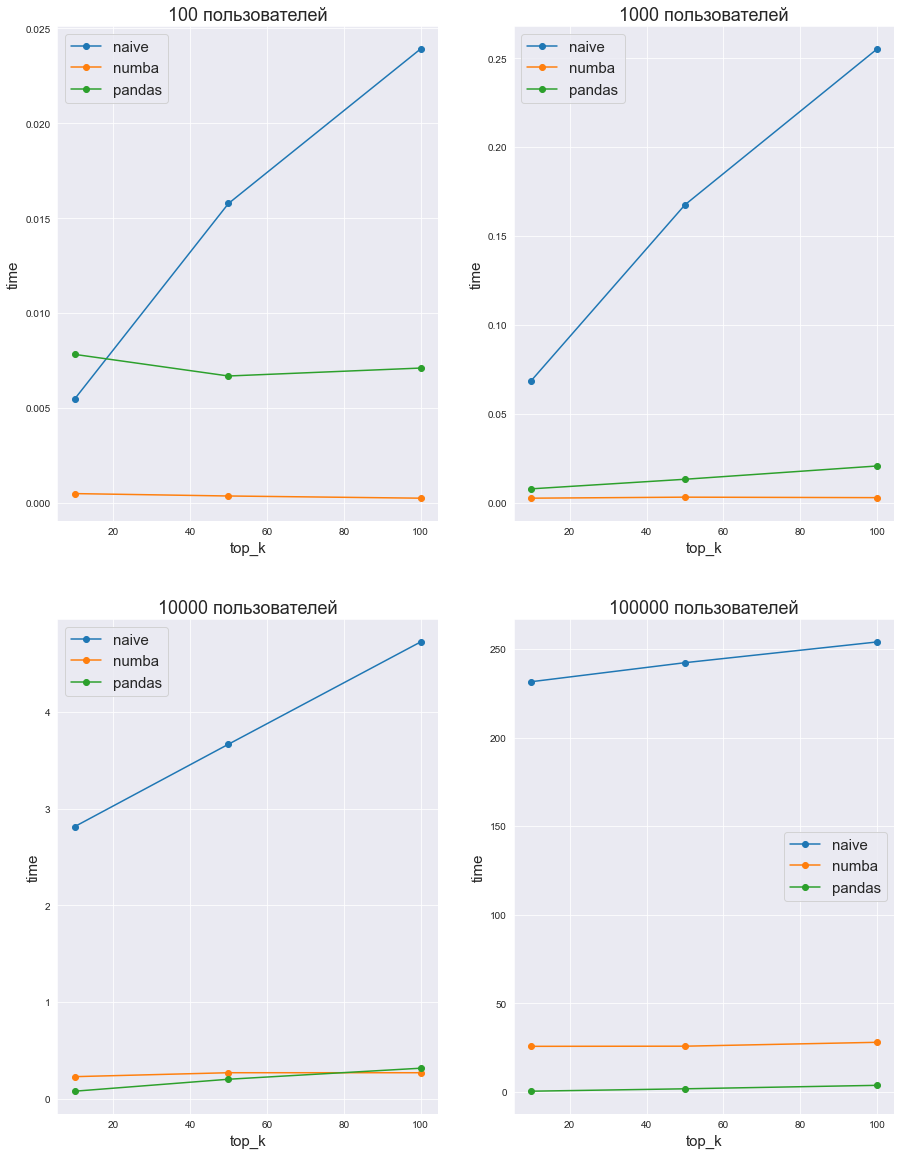

In [478]:
plot(plot_data)